# Uncertainty Estimation using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
#tf.compat.v1.enable_eager_execution()
experimental_run_tf_function=False
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.1.0-dev20191014
TensorFlow Probability version: 0.8.0


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.3 # GPU memory
session = tf.compat.v1.Session(config=config)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

## Build the dataset for regression

In [ ]:
def load_dataset(n, w0, b0, x_low, x_high):
    def s(x):
        g = (x - x_low) / (x_high - x_low)
        return 3 * (0.25 + g**2)
    def f(x, w, b):
        return w * x * (1. + np.sin(x)) + b
    x = (x_high - x_low) * np.random.rand(n) + x_low  # N(x_low, x_high)
    x = np.sort(x)
    eps = np.random.randn(n) * s(x)
    y = f(x, w0, b0) + eps
    return x, y

In [ ]:
n_data = 500
n_train = 400
w0 = 0.125
b0 = 5.0
x_low, x_high = -20, 60

X, y = load_dataset(n_data, w0, b0, x_low, x_high)
X = np.expand_dims(X, 1)
y = np.expand_dims(y, 1)

idx_randperm = np.random.permutation(n_data)
idx_train = np.sort(idx_randperm[:n_train])
idx_test = np.sort(idx_randperm[n_train:])

X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test],y[idx_test]

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)

plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')

In [ ]:
print(X_train[0],y_train[1])

# Traditional point-estimate neural network
## Define the loss function of negative log-likelihood (input as prediction)

In [ ]:
def neg_log_likelihood_with_dist(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

## Define and train the model

In [ ]:
batch_size = 100
n_epochs = 3000
lr = 5e-3

def build_point_estimate_model(scale=1):
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

pe_model = build_point_estimate_model()
pe_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
pe_model.summary()
hist = pe_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, 
                    verbose=1,validation_data=(X_test, y_test))

## Plot the training loss and predict the test data

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'],label='Training data')
ax[0].plot(range(n_epochs), hist.history['val_loss'],label='Testing data')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'],label='Training data')
ax[1].plot(range(n_epochs), hist.history['val_mean_squared_error'],label='Testing data')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_pe = pe_model(X_test)

In [ ]:
y_test_pred_pe.mean()

In [ ]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.scatter(X_test, y_test, marker='*', label='Training data')
plt.plot(X_test, y_test_pred_pe.mean(), 'r-', marker='+', label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

# Estimate aleatoric uncertainty

In [ ]:
def build_aleatoric_model():
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    model_out_loc = Dense(1)(x)
    model_out_scale = Dense(1)(x)
    model_out = DistributionLambda(
        lambda t: tfd.Normal(loc=t[0],scale=1e-7 + 
                             tf.math.softplus(1e-3 * t[1])))([model_out_loc,model_out_scale])
    model = Model(model_in, model_out)
    return model

al_model = build_aleatoric_model()
al_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
al_model.summary()
hist = al_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, 
                    verbose=1, validation_data=(X_test, y_test))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'],label='Training data')
ax[0].plot(range(n_epochs), hist.history['val_loss'],label='Testing data')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].plot(range(n_epochs), hist.history['val_mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
y_test_pred_al = al_model(X_test)
y_test_pred_al_mean = y_test_pred_al.mean()
y_test_pred_al_stddev = y_test_pred_al.stddev()

In [ ]:
y_test_pred_al

## Plot the training and test data

In [ ]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_al_mean, 'r-', marker='+', label='Test data')
plt.fill_between(np.squeeze(X_test), 
                 np.squeeze(y_test_pred_al_mean + 2 * y_test_pred_al_stddev),
                 np.squeeze(y_test_pred_al_mean - 2 * y_test_pred_al_stddev),
                 alpha=0.5, label='Aleatoric uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

# Estimate epistemic uncertainty

In [ ]:
n_epochs = 10000
lr = 5e-3
n_test = 10
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return Sequential([tfp.layers.VariableLayer(2 * n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t[..., :n], scale=1e-7 + tf.nn.softplus(c + t[..., n:])),
                           reinterpreted_batch_ndims=1))])

In [ ]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([tfp.layers.VariableLayer(n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t, scale=1.0), reinterpreted_batch_ndims=1))])

In [ ]:
def build_epistemic_model(train_size, scale=1):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

ep_model = build_epistemic_model(n_train)
ep_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ep_model.summary()
hist = ep_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1,
                             validation_data=(X_test, y_test))

In [ ]:
print({l.name: l.weights for l in ep_model.layers})

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_yscale('log')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_yscale('log')
y_test_pred_ep_list = [ep_model(X_test) for _ in range(15)]
y_test_pred_ep = ep_model(X_test)
y_test_pred_ep_mean = y_test_pred_ep.mean()
y_test_pred_ep_stddev = y_test_pred_ep.stddev()


In [ ]:
#y_test_pred_ep.shape
y_test_pred_ep_list


In [ ]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_ep_mean, 'r-', marker='+', label='Test data')
plt.fill_between(np.squeeze(X_test), 
                 np.squeeze(y_test_pred_ep_mean + 2 * y_test_pred_ep_stddev),
                 np.squeeze(y_test_pred_ep_mean - 2 * y_test_pred_ep_stddev),
                 alpha=0.5, label='Epistemic uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

In [ ]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ep_list):
    y_mean = y.mean()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    avg_mean += y_mean
plt.plot(X_test, avg_mean/n_test, 'g-', marker='+', label='Averaged tests', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

# Estimate aleatoric + epistemic uncertainty

In [ ]:
n_epochs = 30000
def build_aleatoric_epistemic_model(train_size):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    model_out_loc = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                            scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,model_out_scale])
    model = Model(model_in, model_out)
    return model

ae_model = build_aleatoric_epistemic_model(n_train)
ae_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ae_model.summary()
hist = ae_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1,
                   validation_data=(X_test, y_test))

In [ ]:
print({l.name: l.weights for l in ae_model.layers})

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(n_epochs), hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_yscale('log')
ax[1].plot(range(n_epochs), hist.history['mean_squared_error'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_yscale('log')
y_test_pred_ae_list = [ae_model(X_test) for _ in range(n_test)]

In [ ]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ae_list):
    y_mean = y.mean()
    y_stddev = y.stddev()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    plt.fill_between(np.squeeze(X_test), 
                     np.squeeze(y_mean + 2 * y_stddev),
                     np.squeeze(y_mean - 2 * y_stddev),
                     alpha=0.5, label='Aleatoric uncertainties' if i == 0 else None)
    avg_mean += y_mean
plt.plot(X_test, avg_mean/n_test, 'g-', marker='+', label='Averaged tests', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

# Uncertainties in CNNs


In [3]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


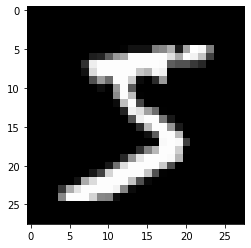

In [4]:
n_class = 10


batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')

In [5]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

In [6]:

def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
______________________________________________________

In [ ]:
print({l.name: l.weights for l in bcnn_model.layers})

In [ ]:
n_mc_run = 100
med_prob_thres = 0.2
ff = [bcnn_model.predict(X_test[0:1],verbose=1)for _ in range(n_mc_run)]
ff_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] 
                                  for y in ff], axis=-1)

In [ ]:
ff_pred_prob_all = np.concatenate([softmax(f,axis=-1) for f in ff])
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in ff_pred_prob_all]
y_pred

In [ ]:
y_pred_logits_list = [bcnn_model.predict(X_test,verbose=1) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

In [ ]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

In [ ]:
idx = 149
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")